<img src="https://habrastorage.org/webt/ia/m9/zk/iam9zkyzqebnf_okxipihkgjwnw.jpeg" />
    
**<center>[mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course** </center><br>
Author: [Yury Kashnitsky](https://yorko.github.io) (@yorko). Edited by Anna Tarelina (@feuerengel).[mlcourse.ai](https://mlcourse.ai) is powered by [OpenDataScience (ods.ai)](https://ods.ai/) © 2017—2021

# <center>Assignment #3. Optional part. Solution </center> <a class="tocSkip">
## <center>Implementation of the decision tree algorithm </center><a class="tocSkip">

If you want to truly understand the algorithm that you are using, it's good to implement it from scratch. Have to say, it's not necessary if you just want to apply an algorithm in practice. However, if you love math, algorithms and programming, you'll enjoy this task.  
<img src='../../_static/img/quote_feynman.jpg' width=50%>

### Your task is to:
 1. write code and perform computations in the cells below;
 2. choose answers in the [webform](https://docs.google.com/forms/d/1SYwUD0Yx_bcykq6EqFQ4Ug0KaQWG4L7bAlL5yGedZnw).
    

*If you are sure that something is not 100% correct with the assignment/solution, please leave your feedback via the mentioned webform ↑*

-----

In [19]:
import numpy as np

# if seaborn is not yet installed, run `pip install seaborn` in terminal
import seaborn as sns
from sklearn.base import BaseEstimator
from sklearn.datasets import (
    fetch_california_housing,
    load_digits,
    make_classification,
    make_regression,
)
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

sns.set()
import matplotlib.pyplot as plt

# sharper plots
%config InlineBackend.figure_format = 'retina'

Let's fix `random_state` (a.k.a. random seed) beforehand.

In [22]:
RANDOM_STATE = 17

**Implement the class `DecisionTree`**
**Specification:**
- the class is inherited from `sklearn.BaseEstimator`;
- class constructor has the following parameters: 
    - `max_depth` - maximum depth of the tree (`numpy.inf` by default); 
    - `min_samples_split` - the minimum number of instances in a node for a splitting to be done (2 by default); 
    - `criterion` - split criterion ('gini' or 'entropy' for classification, 'variance' or 'mad_median' for regression; 'gini' by default);
- the class has several methods: `fit`, `predict` and `predict_proba`;
- the`fit` method takes the matrix of instances `X` and a target vector `y` (`numpy.ndarray` objects) and returns an instance of the class `DecisionTree` representing the decision tree trained on the dataset `(X, y)` according to parameters set in the constructor; 
- the `predict_proba` method takes the matrix of instances `X` and returns the matrix `P` of a size `X.shape[0] x K`, where `K` is the number of classes and $p_{ij}$ is the probability of an instance in $i$-th row of `X` to belong to class $j \in \{1, \dots, K\}$.
- the `predict` method takes the matrix of instances `X` and returns a prediction vector; in case of classification, prediction for an instance $x_i$ falling into leaf $L$ will be the class, mostly represented among instances in $L$. In case of regression, it'll be the mean value of targets for all instances in leaf $L$.

A note on `criterion`: this is the functional to be maximized to find an optimal partition at a given node has the form $Q(X, j, t) = F(X) - \dfrac{|X_l|}{|X|} F(X_l) - \dfrac{|X_r|}{|X|} F(X_r),$ where $X$ are samples at a given node, $X_l$ and $X_r$ are partitions of samples $X$ into two parts with the following condition $[x_j < t]$, and $F(X)$ is a partition criterion.
    
For classification: let $p_i$ be the fraction of the instances of the $i$-th class in the dataset $X$.
- 'gini': Gini impurity $F(X) = 1 -\sum_{i = 1}^K p_i^2$.
- 'entropy': Entropy $F(X) = -\sum_{i = 1}^K p_i \log_2(p_i)$.
    
For regression: $y_j = y(x_j)$ - is a target for an instance $x_j$, $y = (y_1, \dots, y_{|X|})$ - is a target vector.
- 'variance': Variance (mean quadratic deviation from average) $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j - \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2$
- 'mad_median': Mean deviation from the median $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}|y_j - \mathrm{med}(y)|$
    

In [25]:
# Let's define quality criterion:
# entropy and Gini criteria are used for classification
def entropy(y):
    p = [len(y[y == k]) / len(y) for k in np.unique(y)]
    return -np.dot(p, np.log2(p))


def gini(y):
    p = [len(y[y == k]) / len(y) for k in np.unique(y)]
    return 1 - np.dot(p, p)


# variance and median criteria are used for regression
def variance(y):
    return np.var(y)


def mad_median(y):
    return np.mean(np.abs(y - np.median(y)))


criteria_dict = {
    "entropy": entropy,
    "gini": gini,
    "variance": variance,
    "mad_median": mad_median,
}

The `Node` class implements a node in the decision tree.

In [28]:
class Node:
    def __init__(self, feature_idx=0, threshold=0, labels=None, left=None, right=None):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.labels = labels
        self.left = left
        self.right = right

Let's determine the function for calculating a prediction in a leaf. For regression, let's take the mean for all values in a leaf, for classification - the most popular class in leaf.

**Solution:**

In [32]:
def regression_leaf(y):
    return np.mean(y)


def classification_leaf(y):
    return np.bincount(y).argmax()

In [34]:
class DecisionTree(BaseEstimator):
    def __init__(
        self, max_depth=np.inf, min_samples_split=2, criterion="gini", debug=False,
    ):
        # Set parameters
        params = {
            "max_depth": max_depth,
            "min_samples_split": min_samples_split,
            "criterion": criterion,
            "debug": debug,
        }

        for param_name, param_value in params.items():
            setattr(self, param_name, param_value)

        super(DecisionTree, self).set_params(**params)

        self._criterion_function = criteria_dict[criterion]

        if criterion in ["variance", "mad_median"]:
            self._leaf_value = regression_leaf
        else:
            self._leaf_value = classification_leaf

        if self.debug:
            print(f"\nDecisionTree params:\n{params}")

    # Functional for splitting the data by two parts
    def _functional(self, X, y, feature_idx, threshold):
        mask = X[:, feature_idx] < threshold
        n_obj = X.shape[0]
        n_left = np.sum(mask)
        n_right = n_obj - n_left
        if n_left > 0 and n_right > 0:
            return (
                self._criterion_function(y)
                - (n_left / n_obj) * self._criterion_function(y[mask])
                - (n_right / n_obj) * self._criterion_function(y[~mask])
            )
        else:
            return 0

    # Recursive procedure for building decision tree
    def _build_tree(self, X, y, depth=1):
        max_functional = 0
        best_feature_idx = None
        best_threshold = None
        n_samples, n_features = X.shape

        # If all objects in a current vertex have the same values in answers
        # then the value of the functional will be 0 for all partitions.
        # So in this case the vertex is a leaf. In order not to make unnecessary calculations,
        # perform this check before the main cycle.
        if len(np.unique(y)) == 1:
            return Node(labels=y)

        # If the stop criterion is not satisfied, search for the optimal partition
        if depth < self.max_depth and n_samples >= self.min_samples_split:
            if self.debug:
                print("depth = {}, n_samples = {}".format(depth, n_samples))

            # Iterate for all features...
            for feature_idx in range(n_features):
                # and all thresholds for fixed feature
                threshold_values = np.unique(X[:, feature_idx])
                functional_values = [
                    self._functional(X, y, feature_idx, threshold)
                    for threshold in threshold_values
                ]

                best_threshold_idx = np.nanargmax(functional_values)

                if functional_values[best_threshold_idx] > max_functional:
                    max_functional = functional_values[best_threshold_idx]
                    best_threshold = threshold_values[best_threshold_idx]
                    best_feature_idx = feature_idx
                    best_mask = X[:, feature_idx] < best_threshold

        if best_feature_idx is not None:
            if self.debug:
                print(
                    "best feature = {}, best threshold = {}".format(
                        best_feature_idx, best_threshold
                    )
                )
            # In case of partition go next recursivelly...
            return Node(
                feature_idx=best_feature_idx,
                threshold=best_threshold,
                left=self._build_tree(X[best_mask, :], y[best_mask], depth + 1),
                right=self._build_tree(X[~best_mask, :], y[~best_mask], depth + 1),
            )
        else:
            # else the vertex is a leaf, leave recursion
            return Node(labels=y)

    def fit(self, X, y):
        # In classification task memorize the number of classes
        if self.criterion in ["gini", "entropy"]:
            self._n_classes = len(np.unique(y))

        self.root = self._build_tree(X, y)

        return self

    # Predict the answer for single object
    def _predict_object(self, x, node=None):

        node = self.root
        # Traverse from root to the leaf
        while node.labels is None:
            if x[node.feature_idx] < node.threshold:
                node = node.left
            else:
                node = node.right
        # Calculate the answer
        return self._leaf_value(node.labels)

    def predict(self, X):
        return np.array([self._predict_object(x) for x in X])

    def _predict_proba_object(self, x, node=None):

        node = self.root
        # Traverse from root to the leaf
        while node.labels is None:
            if x[node.feature_idx] < node.threshold:
                node = node.left
            else:
                node = node.right
        # Compute probabilities of classes
        return [
            len(node.labels[node.labels == k]) / len(node.labels)
            for k in range(self._n_classes)
        ]

    def predict_proba(self, X):
        return np.array([self._predict_proba_object(x) for x in X])

## Testing the implemented algorithm

### Classification

Let's test our class on synthetic data and make sure that `predict_proba` works correctly.

**Solution:**

Accuracy: 0.85
predict_proba works!


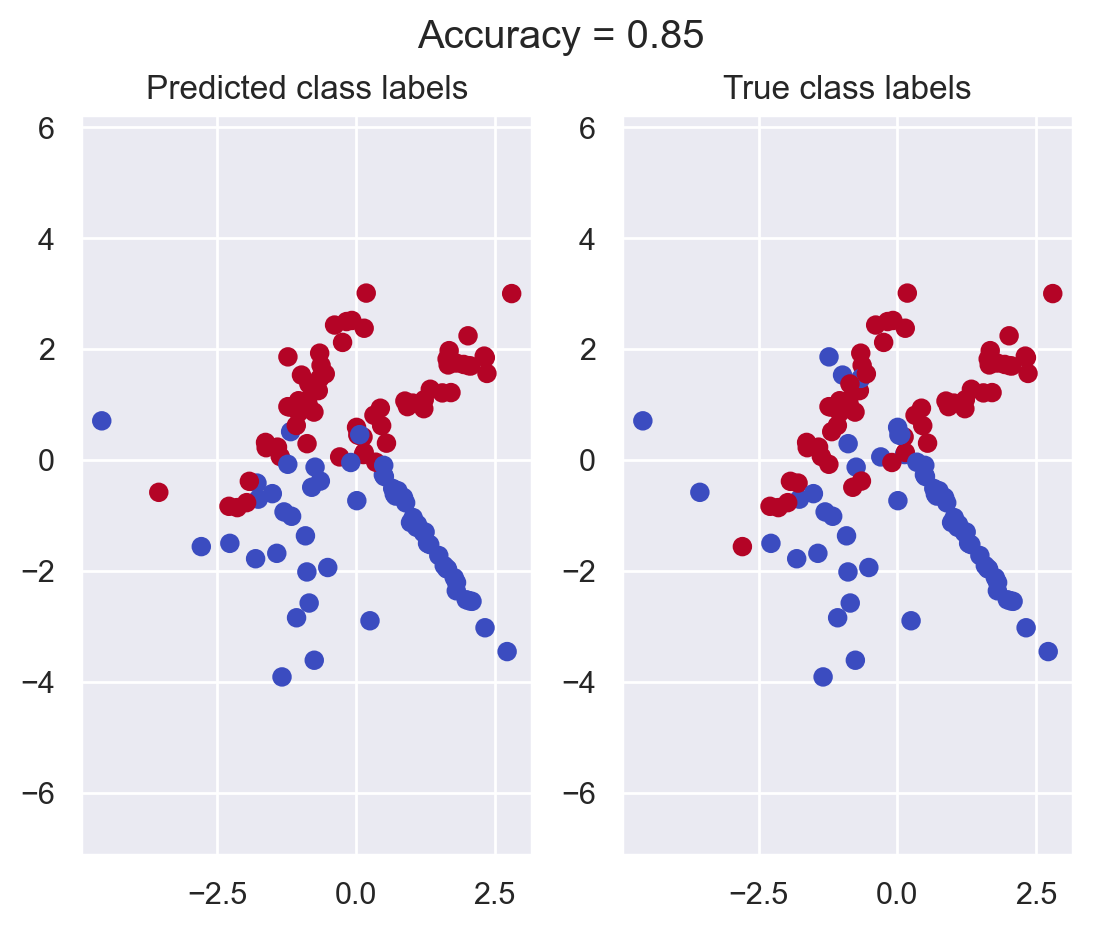

In [40]:
X, y = make_classification(
    n_features=2, n_redundant=0, n_samples=400, random_state=RANDOM_STATE
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE
)

clf = DecisionTree(max_depth=4, criterion="gini")
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
prob_pred = clf.predict_proba(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

if sum(np.argmax(prob_pred, axis=1) - y_pred) == 0:
    print("predict_proba works!")

plt.suptitle("Accuracy = {:.2f}".format(accuracy))
plt.subplot(121)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap=plt.cm.coolwarm)
plt.title("Predicted class labels")
plt.axis("equal")
plt.subplot(122)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm)
plt.title("True class labels")
plt.axis("equal");

Download the dataset `digits` using the method `load_digits`. Split the data into train and test with the `train_test_split` method, use parameter values `test_size=0.2`, and `random_state=17`. Try to train shallow decision trees and make sure that gini and entropy criteria return different results.

In [50]:
digits = load_digits()

X = digits.data
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

clf1 = DecisionTree(max_depth=5, criterion="gini", debug=True)
clf1.fit(X_train, y_train)

print(accuracy_score(clf1.predict(X_test), y_test))
print(clf.predict(X_test))


clf2 = DecisionTree(max_depth=5, criterion="entropy", debug=True)
clf2.fit(X_train, y_train)

print(accuracy_score(clf2.predict(X_test), y_test))
print(clf2.predict(X_test))


DecisionTree params:
{'max_depth': 5, 'min_samples_split': 2, 'criterion': 'gini', 'debug': True}
depth = 1, n_samples = 1437
best feature = 36, best threshold = 1.0
depth = 2, n_samples = 215
best feature = 42, best threshold = 6.0
depth = 3, n_samples = 58
best feature = 21, best threshold = 7.0
depth = 4, n_samples = 16
best feature = 4, best threshold = 12.0
depth = 4, n_samples = 42
best feature = 13, best threshold = 3.0
depth = 3, n_samples = 157
best feature = 21, best threshold = 1.0
depth = 4, n_samples = 10
best feature = 1, best threshold = 2.0
depth = 4, n_samples = 147
best feature = 28, best threshold = 5.0
depth = 2, n_samples = 1222
best feature = 21, best threshold = 1.0
depth = 3, n_samples = 373
best feature = 42, best threshold = 9.0
depth = 4, n_samples = 194
best feature = 5, best threshold = 2.0
depth = 4, n_samples = 179
best feature = 54, best threshold = 3.0
depth = 3, n_samples = 849
best feature = 60, best threshold = 8.0
depth = 4, n_samples = 196
best fe

Using 5-folds cross-validation (`GridSearchCV`) pick up the optimal values of the `max_depth` and `criterion` parameters. For the parameter `max_depth` use range(3, 11), for criterion use {'gini', 'entropy'}. Quality measure is `scoring`='accuracy'.

**Solution:**

_Note: starting from `sklearn` version 0.23, the `GridSearchCV` object does not correctly process all passed attribute values, in my case, it ignored `criterion` when passed to `param_grid`. Therefore, here I train separate `GridSearchCV` objects for different criterion choices: `gini` and `entropy`._

In [9]:
%%time
tree_params = {"max_depth": list(range(3, 11))}

grid_clf_crit_gini = GridSearchCV(
    estimator=DecisionTree(criterion="gini"),
    param_grid=tree_params,
    cv=5,
    scoring="accuracy",
    n_jobs=4,
)

grid_clf_crit_gini.fit(X_train, y_train)

print(grid_clf_crit_gini.best_score_, grid_clf_crit_gini.best_params_)

0.8434306039488966 {'max_depth': 10}
CPU times: user 5.26 s, sys: 93.7 ms, total: 5.35 s
Wall time: 44.5 s


In [10]:
grid_clf_crit_entropy = GridSearchCV(
    estimator=DecisionTree(criterion="entropy"),
    param_grid=tree_params,
    cv=5,
    scoring="accuracy",
    n_jobs=4,
)

grid_clf_crit_entropy.fit(X_train, y_train)

print(grid_clf_crit_entropy.best_score_, grid_clf_crit_entropy.best_params_)

0.8629186024003097 {'max_depth': 9}


Draw the plot of the mean quality measure `accuracy` for criteria `gini` and `entropy` depending on `max_depth`.

**Solution:**

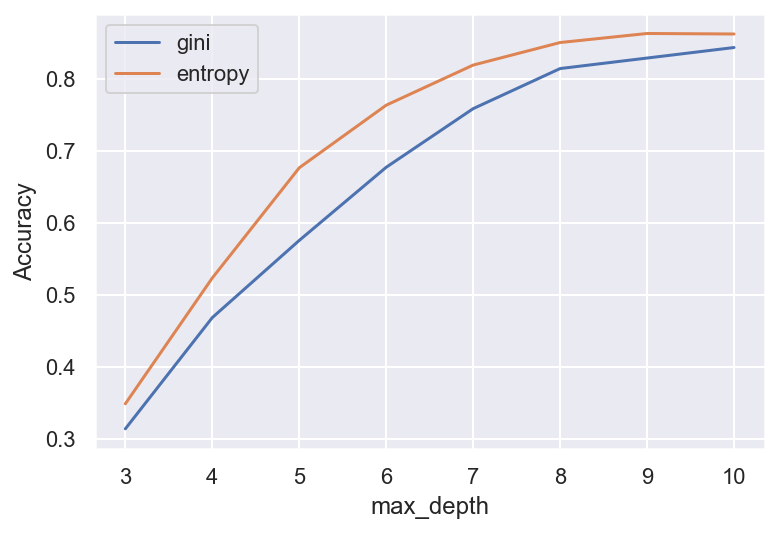

In [11]:
scores_for_crit_gini = np.array(grid_clf_crit_gini.cv_results_["mean_test_score"])
scores_for_crit_entropy = np.array(grid_clf_crit_entropy.cv_results_["mean_test_score"])

plt.plot(tree_params["max_depth"], scores_for_crit_gini, label="gini")
plt.plot(tree_params["max_depth"], scores_for_crit_entropy, label="entropy")
plt.legend(loc="best")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.show();

**<font color='red'>Question 1.</font> Choose all correct statements:**
1. The optimal value of the `max_depth` parameter is on the interval [4, 9] for both criteria: "gini" and "entropy"
2. Created plots have no intersection on the interval [3, 10]. **<font color='red'>[+]</font>**
3. Created plots intersect each other only once on the interval [3, 10].
4. The best quality for `max_depth` on the interval [3, 10] is reached using `gini` criterion .
5. Accuracy is strictly increasing at least for one of the criteria, when `max_depth` is also increasing on the interval [3, 10]. **<font color='red'>[+]</font>**

**<font color='red'>Question 2.</font> What are the optimal values for max_depth and criterion parameters?**
1. max_depth = 7, criterion = 'gini';
2. max_depth = 7, criterion = 'entropy';
3. max_depth = 10, criterion = 'entropy';
4. max_depth = 10, criterion = 'gini';
5. max_depth = 9, criterion = 'entropy'; **<font color='red'>[+]</font>**
6. max_depth = 9, criterion = 'gini';

Train decision tree on `(X_train, y_train)` using the optimal values of `max_depth` and `criterion`. Compute class probabilities for `X_test`.

In [12]:
clf = DecisionTree(max_depth=9, criterion="entropy")
clf.fit(X_train, y_train)
probs = clf.predict_proba(X_test)

Using the given matrix, compute the mean class probabilities for all instances in `X_test`.

In [13]:
mean_probs = np.mean(probs, axis=0)
print(mean_probs, max(mean_probs))

[0.09166667 0.07700282 0.09854938 0.08930086 0.12690476 0.11898148
 0.08194444 0.09805556 0.10465062 0.11294341] 0.12690476190476194


**<font color='red'>Question 3.</font> What is the maximum probability in the resulted vector?**
1. 0.127 **<font color='red'>[+]</font>**
2. 0.118
3. 1.0
4. 0.09

## Regression

Let's do the same for regression.

Mean Squared Error: 59.840630785192516


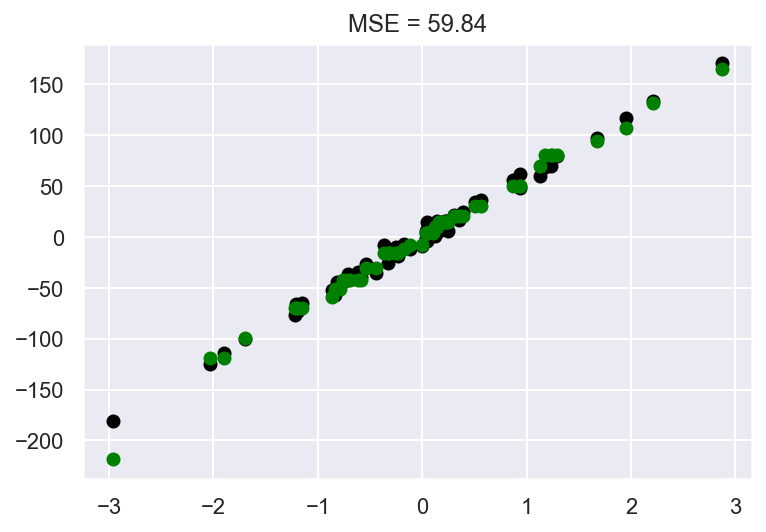

In [14]:
X, y = make_regression(
    n_features=1, n_samples=200, bias=0, noise=5, random_state=RANDOM_STATE
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

reg = DecisionTree(max_depth=6, criterion="mad_median")
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

plt.scatter(X_test[:, 0], y_test, color="black")
plt.scatter(X_test[:, 0], y_pred, color="green")
plt.title("MSE = {:.2f}".format(mse));

Download the dataset `boston` using the method `load_boston`. Split the data into train and test with the `train_test_split` method, use parameter values `test_size=0.2`, `random_state=17`. Try to train shallow regression decision trees and make sure that `variance` and `mad_median` criteria return different results.

**Solution:**

In [15]:
boston = load_boston()

X = boston.data
y = boston.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

clf1 = DecisionTree(max_depth=2, criterion="variance", debug=True)
clf1.fit(X_train, y_train)

print(mean_squared_error(clf1.predict(X_test), y_test))


clf2 = DecisionTree(max_depth=2, criterion="mad_median", debug=True)
clf2.fit(X_train, y_train)

print(mean_squared_error(clf2.predict(X_test), y_test))


DecisionTree params:
{'max_depth': 2, 'min_samples_split': 2, 'criterion': 'variance', 'debug': True}
depth = 1, n_samples = 404


/Users/kashnitskiyy/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the Californi

best feature = 12, best threshold = 7.51
54.63221936139991

DecisionTree params:
{'max_depth': 2, 'min_samples_split': 2, 'criterion': 'mad_median', 'debug': True}
depth = 1, n_samples = 404
best feature = 5, best threshold = 6.8
40.82003832415897


Using 5-folds cross-validation (`GridSearchCV`) pick up the optimal values of the `max_depth` and `criterion` parameters. For the parameter `max_depth` use `range(2, 9)`, for `criterion` use {'variance', 'mad_median'}. Quality measure is `scoring`='neg_mean_squared_error'.

**Solution:**

_Note: starting from `sklearn` version 0.23, the `GridSearchCV` object does not correctly process all passed attribute values, in my case, it ignored `criterion` when passed to `param_grid`. Therefore, here I train separate `GridSearchCV` objects for different criterion choices: `mad_median` and `variance`._

In [16]:
%%time
tree_params = {"max_depth": list(range(2, 9))}

grid_reg_crit_mad_median = GridSearchCV(
    estimator=DecisionTree(criterion="mad_median"),
    param_grid=tree_params,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=8,
)

grid_reg_crit_mad_median.fit(X_train, y_train)

CPU times: user 1.71 s, sys: 97.5 ms, total: 1.8 s
Wall time: 14.9 s


GridSearchCV(cv=5, estimator=DecisionTree(criterion='mad_median'), n_jobs=8,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8]},
             scoring='neg_mean_squared_error')

In [17]:
grid_reg_crit_variance = GridSearchCV(
    estimator=DecisionTree(criterion="variance"),
    param_grid=tree_params,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=8,
)

grid_reg_crit_variance.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTree(criterion='variance'), n_jobs=8,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8]},
             scoring='neg_mean_squared_error')

Draw the plot of the mean quality measure `neg_mean_squared_error` for criteria `variance` and `mad_median` depending on `max_depth`.

**Solution:**

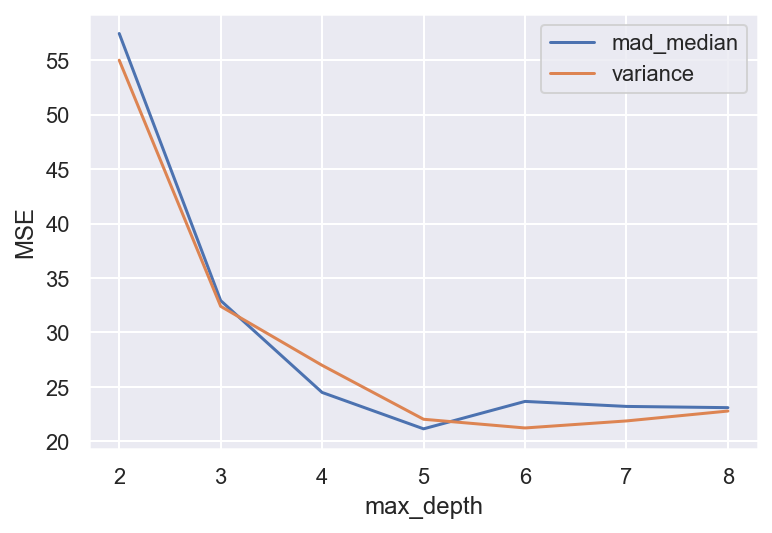

In [18]:
scores_for_crit_mad_median = -np.array(
    grid_reg_crit_mad_median.cv_results_["mean_test_score"]
)
scores_for_crit_variance = -np.array(
    grid_reg_crit_variance.cv_results_["mean_test_score"]
)

plt.plot(tree_params["max_depth"], scores_for_crit_mad_median, label="mad_median")
plt.plot(tree_params["max_depth"], scores_for_crit_variance, label="variance")
plt.legend()
plt.xlabel("max_depth")
plt.ylabel("MSE")
plt.show();

**<font color='red'>Question 4.</font> Choose all correct statements:**
1. Created plots have no intersection on the interval [2, 8].
2. Created plots intersect each other only once on the interval [2, 8].
3. Optimal value of the `max_depth` for each of the criteria is on the border of the interval [2, 8].
4. The best quality at `max_depth` on the interval [2, 8] is reached using `mad_median` criterion **<font color='red'>[+]</font>**

**<font color='red'>Question 5.</font> What are the optimal values for `max_depth` and `criterion` parameters?**
1. max_depth = 9, criterion = 'variance';
2. max_depth = 5, criterion = 'mad_median'; **<font color='red'>[+]</font>**
3. max_depth = 4, criterion = 'variance';
4. max_depth = 2, criterion = 'mad_median';
5. max_depth = 4, criterion = 'mad_median';
6. max_depth = 5, criterion = 'variance'.

**Solution:**

In [19]:
print("Criterion: mad_median")
print("Best params:", grid_reg_crit_mad_median.best_params_)
print("Best cross validaton MSE:", abs(grid_reg_crit_mad_median.best_score_))

print("Criterion: variance")
print("Best params:", grid_reg_crit_variance.best_params_)
print("Best cross validaton MSE:", abs(grid_reg_crit_variance.best_score_))

Criterion: mad_median
Best params: {'max_depth': 5}
Best cross validaton MSE: 21.157004600133206
Criterion: variance
Best params: {'max_depth': 6}
Best cross validaton MSE: 21.23696740219734
